# AdaptiveGraph: Customer Support Agent Demo

This interactive notebook demonstrates the **'Tiered Customer Support Agent'** use case.

**Scenario:** You have 3 support channels with different costs and capabilities:
1.  **QuickBot** (Free, Instant): Handles simple FAQs like "reset password". Fails on complex queries.
2.  **RAG Agent** (Medium Cost): Uses docs to answer questions. Can sometimes timeout/crash.
3.  **Human Expert** (Expensive): Solves everything perfectly.

**Goal:** Build an agent that learns to route tickets to the cheapest channel that can successfully solve the problem.

In [ ]:
# Install dependencies if running in Colab/Fresh Env
%pip install -e "..[all]"

In [1]:
import sys
import os
import random
import uuid
import time
import matplotlib.pyplot as plt
from typing import TypedDict, Literal, Optional
from langgraph.graph import StateGraph, END
from adaptivegraph import LearnableEdge, ErrorScorer, LLMScorer

### 1. Define the Agent State

In [2]:
class SupportState(TypedDict):
    ticket_id: str          # Trace ID / Session ID
    user_tier: str          # "Free" or "Premium"
    query: str              # User text
    
    # Internal Flow
    route_decision: str     # Where did we go?
    tool_output: str        # Tool result
    error: Optional[str]    # Did tool crash?
    
    trace_id: str           # Required for Trajectory Rewards
    event_id: str           # Required for Async User Feedback

### 2. Define the Router (The Brain)

We use `LearnableEdge` with `sentence-transformers` embedding. This allows the router to understand the *meaning* of the support ticket ("My screen is black" ~= "Display failure").

In [3]:
router = LearnableEdge.create(
    options=["quick_bot", "rag_agent", "human_expert"],
    embedding="sentence-transformers",
    memory="memory", # Transient memory for this demo
    feature_dim=384,
    value_key="query" # Route based on the 'query' text
)
print("Router Initialized!")

Router Initialized!


### 3. Define the Nodes (The Workers)

These simulate our support channels.

In [4]:
def triage_node(state: SupportState):
    # Entry point
    return state

def quick_bot_node(state: SupportState):
    # Only handles simple keywords
    if "reset" in state["query"].lower() or "password" in state["query"].lower():
        return {"tool_output": "Here is the link to reset password.", "route_decision": "quick_bot"}
    else:
        # Failure case
        return {"tool_output": "Unknown command.", "error": "BotConfused", "route_decision": "quick_bot"}

def rag_agent_node(state: SupportState):
    # Simulates RAG. Has a chance of crashing (Timeout)
    if "error" in state["query"].lower() and random.random() < 0.3:
        return {"tool_output": "", "error": "VectorDBTimeout", "route_decision": "rag_agent"}
    return {"tool_output": f"Docs result for '{state['query']}'", "route_decision": "rag_agent"}

def human_expert_node(state: SupportState):
    # Always works
    return {"tool_output": "Human: I fixed it for you.", "route_decision": "human_expert"}

### 4. Build the Graph

In [5]:
workflow = StateGraph(SupportState)

workflow.add_node("triage", triage_node)
workflow.add_node("quick_bot", quick_bot_node)
workflow.add_node("rag_agent", rag_agent_node)
workflow.add_node("human_expert", human_expert_node)

workflow.set_entry_point("triage")

# The Routing Magic Happens Here
workflow.add_conditional_edges(
    "triage",
    router,
    {
        "quick_bot": "quick_bot",
        "rag_agent": "rag_agent",
        "human_expert": "human_expert"
    }
)

workflow.add_edge("quick_bot", END)
workflow.add_edge("rag_agent", END)
workflow.add_edge("human_expert", END)

app = workflow.compile()

### 5. Demo: Async User Feedback (ID-Based)

This demonstrates how a user can provide feedback **hours later** by simply referencing the ticket ID.

In [6]:
print("=== Async User Feedback Demo ===")

# Step 1: User submits a ticket
ticket_id = "TICKET-12345"
user_query = "I need help with billing"

state = {
    "ticket_id": ticket_id,
    "event_id": ticket_id,  # The router will track this decision by this ID
    "trace_id": ticket_id,
    "user_tier": "Premium",
    "query": user_query,
    "route_decision": "",
    "tool_output": "",
    "error": None
}

# Step 2: Agent processes the ticket
result = app.invoke(state)
print(f"Ticket {ticket_id} processed.")
print(f"  Query: '{user_query}'")
print(f"  Routed to: {result['route_decision']}")
print(f"  Response: {result['tool_output']}")

# Step 3: Simulate time passing (2 hours later...)
print("\n[2 hours later...]")

# Step 4: User clicks 'Thumbs Up' in an email
user_rating = 1.0  # Happy!
print(f"User rated ticket {ticket_id}: {user_rating} (Thumbs Up!)")

# Step 5: Backend receives the feedback and updates the router
router.record_feedback(result={}, reward=user_rating, event_id=ticket_id)
print(f"Router updated based on user feedback for ticket {ticket_id}.")
print("\nThis decision is now stored in memory and will influence future routing!")

=== Async User Feedback Demo ===
Ticket TICKET-12345 processed.
  Query: 'I need help with billing'
  Routed to: quick_bot
  Response: Unknown command.

[2 hours later...]
User rated ticket TICKET-12345: 1.0 (Thumbs Up!)
Router updated based on user feedback for ticket TICKET-12345.

This decision is now stored in memory and will influence future routing!


### 6. Interactive Simulation

Now let's run a full simulation with trajectory rewards.

In [7]:
error_scorer = ErrorScorer(penalty=-1.0, success_reward=0.1)

# Store history for plotting
global_reward_history = []

def run_ticket_simulation(num_tickets=50):
    queries = [
        ("How do I reset my password?", "quick_bot"),     # Simple -> Bot
        ("Critical server error 500", "human_expert"),    # Complex -> Human
        ("Where are the docs?", "rag_agent"),             # Medium -> RAG
        ("I want a refund!", "human_expert"),             # Money/Angry -> Human
    ]
    
    async_feedback_queue = []
    
    print(f"--- Processing {num_tickets} Tickets ---")
    
    for i in range(num_tickets):
        q_text, ideal_route = random.choice(queries)
        t_id = str(uuid.uuid4())[:6]
        
        state = {
            "ticket_id": t_id,
            "event_id": t_id,
            "user_tier": "Free",
            "query": q_text,
            "trace_id": t_id, # CRITICAL for Trajectory Rewards
            "route_decision": "", "tool_output": "", "error": None
        }
        
        # RUN AGENT
        result = app.invoke(state)
        path = result['route_decision']
        
        # 1. CHECK FOR CRASHES (Immediate)
        crash_score = error_scorer.score(result)
        if crash_score < 0:
            print(f"[{t_id}] CRASH! Tool '{path}' failed ({result['error']}). Penalty Applied.")
            router.complete_trace(t_id, final_reward=-1.0)
            global_reward_history.append(-1.0)
            continue
            
        # 2. QUEUE FOR USER FEEDBACK (Delayed)
        # Simulate user happiness
        satisfaction = 0.1
        if path == ideal_route: satisfaction = 1.0
        elif path == "human_expert": satisfaction = 0.9 # Everyone likes humans
        elif path == "quick_bot" and ideal_route != "quick_bot": satisfaction = 0.0 # Hated it
        
        async_feedback_queue.append({"id": t_id, "score": satisfaction, "query": q_text, "path": path})

        # Process Feedback every 5 tickets
        if len(async_feedback_queue) >= 5:
            for item in async_feedback_queue:
                # RETROSPECTIVE REWARD
                router.complete_trace(item["id"], final_reward=item["score"])
                global_reward_history.append(item["score"])
            async_feedback_queue = []
    print("Done!")


In [8]:
# Run it!
run_ticket_simulation(50)

--- Processing 50 Tickets ---
[0b7e50] CRASH! Tool 'quick_bot' failed (BotConfused). Penalty Applied.
[8faa8c] CRASH! Tool 'quick_bot' failed (BotConfused). Penalty Applied.
[921034] CRASH! Tool 'quick_bot' failed (BotConfused). Penalty Applied.
Done!


### 7. Visualize Improvement
See how the reward (Satisfaction) increases over time as the router learns.

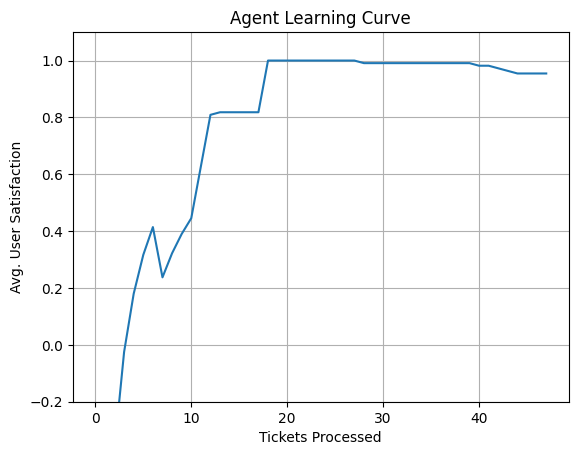

In [9]:
def moving_average(a, n=5):
    ret = []
    for i in range(len(a)):
        subset = a[max(0, i-n):i+1]
        ret.append(sum(subset)/len(subset))
    return ret

smoothed = moving_average(global_reward_history, 10)
plt.plot(smoothed)
plt.xlabel("Tickets Processed")
plt.ylabel("Avg. User Satisfaction")
plt.title("Agent Learning Curve")
plt.ylim(-0.2, 1.1)
plt.grid(True)
plt.show()

### 8. Bonus: LLM-as-a-Judge
Instead of waiting for a human, we can ask an LLM to rate the answer immediately.

In [10]:
# Mock LLM for demo purposes (you would use OpenAI/Anthropic in real life)
class MockChain:
    def invoke(self, prompt: str) -> str:
        if "bad" in prompt.lower() or "error" in prompt.lower():
            return "Score: 2/10"
        return "Score: 9/10"

mock_llm = MockChain()

llm_scorer = LLMScorer(mock_llm, prompt_template="Rate this response: {response} for query: {query}")

# Demo:
score = llm_scorer.score(query="Help me", response="Here is a helpful answer.")
print(f"LLM Scorer gave: {score}")

score_bad = llm_scorer.score(query="Help me", response="System Error 500")
print(f"LLM Scorer gave (bad): {score_bad}")

LLM Scorer gave: 9.0
LLM Scorer gave (bad): 2.0


### Conclusion

We have demonstrated:
1. **Async User Feedback**: Users can rate tickets hours later using just the ticket ID.
2. **Semantic Routing**: Learning from text.
3. **Safety**: Catching tool crashes with `ErrorScorer`.
4. **Long-term Optimization**: Using Trajectory Rewards to optimize for the final outcome.
5. **Visualization**: Seeing the policy improve over time.
6. **LLM Judge**: Automatic quality scoring.